# Exploring PDFs

Goals: To play with plots of probability density functions (pdfs) using the `scipy.stats` and `numpy` libraries. 
Work through the notebook but don't just follow the instructions.  Explore!

**Answer the questions in** *italics*. **Check with your neighbors and ask for help if you get stuck or are unsure.**

## Quick overview: To a Bayesian, everything is a pdf (probability density function)

Physicists are used to dealing with pdfs as normalized wave functions squared.  For a one-dimensional particle, the probability density at $x$ is

<span style="color: red">
 $$
 |\Psi(x)|^2 \Longrightarrow p(x) 
 $$
</span> 

The *probability* of finding $x$ in some interval $a \leq x \leq b$ is found by integration:

<span style="color: red">
 $$
 p(a \leq x \leq b) = \int_a^b |\Psi(x)|^2 \; dx 
 $$
</span> 


Just as with "Lagrangian" vs. "Lagrangian density", physicists are not always careful when saying probability vs. probability density.

Physicists are also used to multidimensional normalized pdfs as wave functions squared, e.g. probability density for particle 1 at $x_1$ and particle 2 at $x_2$:

<span style="color: red">
 $$
 |\Psi(x_1, x_2)|^2 \Longrightarrow p(x_1,x_2) \equiv p(\textbf{x})  
   \quad \mbox{with}\quad \textbf{x} 
 \equiv \{x_1,x_2\}
 $$
</span> 

(Note that you will find alternative notation in the physics and statistics literature for generic pdfs: $p(\textbf{x}) = P(\textbf{x}) = \textrm{pr}(\textbf{x}) = \textrm{prob}(\textbf{x}) = \ldots$ )

Some other vocabulary and definitions:
* $p(x_1,x_2)$ is the <em>joint probability density</em> of $x_1$ and $x_2$. <br>
* What is the probability to find particle 1 at $x_1$ and particle 2 anywhere?  $\color{blue}{\int\! |\Psi(x_1,x_2)|^2 dx_2}$ (integrated over the full domain of $x_2$, e.g., 0 to $\infty$).<br>
* The <em>marginal probability density</em> of $x_1$ is: 
$\color{blue}{p(x_1) = \int\! p(x_1,x_2)\,dx_2}$. <br>
* "Marginalizing" = "integrating out" (eliminates from the posterior the "nuisance parameters" whose value you don't care about).  

In Bayesian statistics there are pdfs (or pmfs if discrete) for experimental <i>and</i> theoretical uncertainties, fit parameters, hyperparameters (what are those?), events ("Will it rain tomorrow?"), etc.  Even if $x$ has the definite value $x_0$, we can use the pdf $p(x) = \delta(x-x_0)$.  

*Questions?*

In [1]:
# set up for plots in this notebook using matplotlib 
%matplotlib inline   

In [2]:
import scipy.stats as stats  # We'll use stats as our source of pdfs
import numpy as np

import matplotlib.pyplot as plt
import corner  # for making "corner plots" showing 2-dimensional posteriors

import seaborn as sns; sns.set()  # nicer plots!

## Visualization of pdfs


### Quick introduction to  `scipy.stats`

If you google "scipy.stats", you'll likely get the manual page as the first hit: [https://docs.scipy.org/doc/scipy/reference/stats.html].  Here you'll find a long list of the continuous and discrete distributions that are available, followed (scroll way down) by many different methods (functions) to extract properties of a distribution (called "Summary Statistics) and do many other statistical tasks.

Follow the link for any of the distributions (your choice!) to find its mathematical definition, some examples of how to use it, and a list of methods. Some methods of interest to us here:
* mean() - Mean of the distribution.
* median() - Median of the distribution.
* pdf(x) - Value of the probability density function at x.
* rvs(size=num_pts) - generate num_pts random values of the pdf.
* interval(alpha) - Endpoints of the range that contains alpha percent of the distribution.

*Try out some of the examples* (cut-and-paste after turning off the >>> in the upper right of a box).  We'll use all of these methods in explicit examples below.

### Matplotlib plotting definitions

We first define a few functions that we'll use to extract and plot quantities of interest. 

*After you've looked at the examples that follow, come back and make sure you know what the functions are doing.*

In [3]:
def dist_stuff(dist):
    """
    Finds the median, mean, and 68%/95% credible intervals for the given 
    1-d distribution (which is an object from scipy.stats).  
    """
    # For x = median, mean: return x and the value of the pdf at x as a list
    median = [dist.median(), dist.pdf(dist.median())]  
    mean = [dist.mean(), dist.pdf(dist.mean())]
    # The left and right limits of the credibility interval are returned
    cred68 = dist.interval(0.68)
    cred95 = dist.interval(0.95)
    return median, mean, cred68, cred95

def dist_mode(dist, x):
    """
    Return the mode (maximum) of the 1-d distribution for array x.
    """
    x_max_index = dist.pdf(x).argmax()
    # Return x of the maximum and the value of the pdf at that x 
    mode = [x[x_max_index], dist.pdf(x[x_max_index])]
    return mode

def dist_plot(ax, dist_label, x_dist, dist, color='blue'):
    """
    Plot the distribution, indicating median, mean, mode
    and 68%/95% probability intervals on the axis that is passed.
    """
    median, mean, cred68, cred95 = dist_stuff(dist)
    mode = dist_mode(dist, x_dist)
    
    ax.plot(x_dist, dist.pdf(x_dist), label=dist_label, color=color)    
    ax.set_xlabel('x')
    ax.set_ylabel('p(x)')
    
    # Point to the median, mode, and mean with arrows (adjusting the spacing)
    text_x = 0.2*(x_dist[-1]-x_dist[0])
    text_x_mid = (x_dist[-1]+x_dist[0])/2.
    text_y = mode[1]*1.15
    ax.annotate('median', xy=median, xytext=(text_x_mid+text_x, text_y),
                arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate('mode', xy=mode, xytext=(text_x_mid-text_x, text_y),
                arrowprops=dict(facecolor='red', shrink=0.05))
    ax.annotate('mean', xy=mean, xytext=(text_x_mid, text_y),
                arrowprops=dict(facecolor='blue', shrink=0.05))
    
    # Mark the credible intervals using shading (with appropriate alpha)
    ax.fill_between(x_dist, 0, dist.pdf(x_dist), 
                    where=((x_dist > cred68[0]) & (x_dist < cred68[1])), 
                    facecolor='blue', alpha=0.2)
    ax.fill_between(x_dist, 0, dist.pdf(x_dist), 
                    where=((x_dist > cred95[0]) & (x_dist < cred95[1])), 
                    facecolor='blue', alpha=0.1)
    
    ax.legend();


### Some standard pdfs: normal and beta distributions

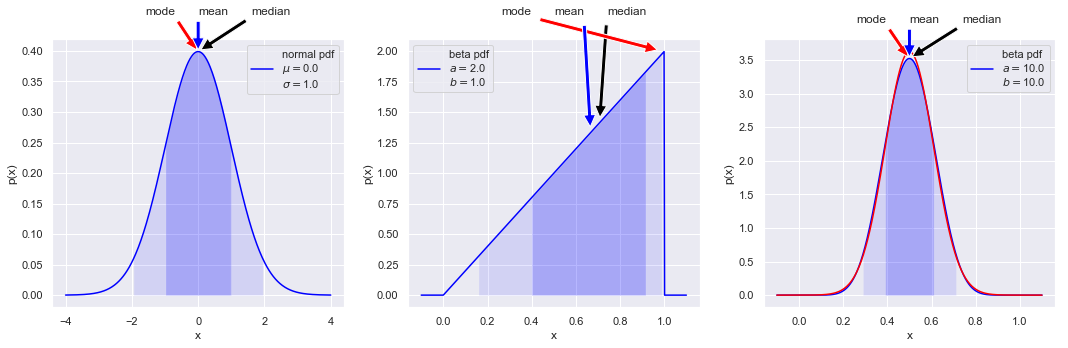

In [4]:
# Make some standard plots: normal, beta
fig = plt.figure(figsize=(15,5))

# Standard normal distribution -- try changing the mean and std. dev. 
x_norm = np.linspace(-4, 4, 500)
mu = 0       # mean
sigma = 1.0  # standard deviation
norm_dist = stats.norm(mu, sigma) # the normal distribution from scipy.stats
norm_label='normal pdf' + '\n' + rf'$\mu=${mu:1.1f}' \
             + '\n' + rf'$\sigma=${sigma:1.1f}' 
ax1 = fig.add_subplot(1,3,1)
dist_plot(ax1, norm_label, x_norm, norm_dist)

# beta distribution, characterized by a and b parameters
x_beta = np.linspace(-0.1, 1.1, 500)  # beta ranges from 0 to 1 
a1 = 2
b1 = 1
beta_dist = stats.beta(a1, b1)  # the beta distribution from scipy.stats
beta1_label='beta pdf' + '\n' + rf'$a=${a1:1.1f}' \
              + '\n' + rf'$b=${b1:1.1f}'
ax2 = fig.add_subplot(1,3,2)
dist_plot(ax2, beta1_label, x_beta, beta_dist)

# another beta distribution
#x_beta = np.linspace(-0.1, 1.1, 500)
a2 = 10
b2 = 10
beta2_dist = stats.beta(a2, b2)
beta2_label='beta pdf' + '\n' + rf'$a=${a2:1.1f}' \
              + '\n' + rf'$b=${b2:1.1f}' 
ax3 = fig.add_subplot(1,3,3)
dist_plot(ax3, beta2_label, x_beta, beta2_dist)

mu2 = 0.5
sigma2 = 0.11
norm2_dist = stats.norm(mu2, sigma2)
ax3.plot(x_beta, norm2_dist.pdf(x_beta), color='red')

fig.tight_layout()

The 68%/95% probability regions are shown in dark/light shading.  When applied to Bayesian posteriors, these are known as <em>credible intervals</em> or DoBs (degree of belief intervals) or Bayesian confidence intervals. The horizontal extent on the $x$-axis translates into the vertical extent of the error bar or error band for $x$.


The values of the mode, mean, median can be used as *point estimates* for the "probable" value of $x$.  
*If you had a symmetric bimodal distribution, what point estimate would be best?  Or are they all poor?* 

Things to try:
* Change the normal (Gaussian) distribution so that the mean is non-zero and the standard deviation is not unity.
* Add another plot to one of the graphs. E.g., generate a normal distribution with the same mean and about the same width as the beta distribution with $a=10$, $b=10$ and add it to that plot.  You don't need to call a special function, just use `norm2_dist = stats.norm(mu2, sigma2)` with your guesses for the $\mu$ and $\sigma$ values and then `ax3.plot(x_beta, norm2_dist.pdf(x_beta), color='red')` to overlay the curve on `ax3`.  
* Try some other distributions.

### Another standard class of pdf:  Student t

*Find the functional definition on the web page.  Is it consistent with the plots?*

*What are the `loc` and `scale` parameters?*

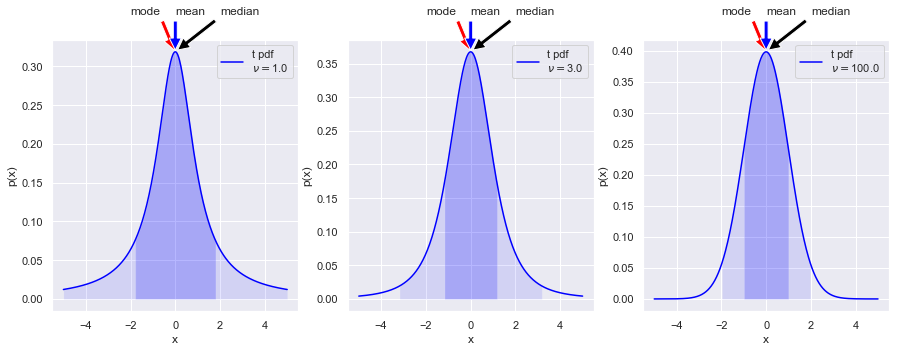

In [5]:

# Make some plots of the Student t distribution
fig = plt.figure(figsize=(15,5))

x_t = np.linspace(-5, 5, 500)

nu1 = 1.01
t1_dist = stats.t(nu1) # the Student t distribution
t1_label='t pdf' + '\n' + rf'$\nu=${nu1:1.1f}'
ax1 = fig.add_subplot(1,3,1)
dist_plot(ax1, t1_label, x_t, t1_dist)

nu2 = 3
t2_dist = stats.t(nu2) # the Student t distribution
t2_label = 't pdf' + '\n' + rf'$\nu=${nu2:1.1f}'
ax2 = fig.add_subplot(1,3,2)
dist_plot(ax2, t2_label, x_t, t2_dist)

nu3 = 100
t3_dist = stats.t(nu3) # the Student t distribution
t3_label = 't pdf' + '\n' + rf'$\nu=${nu3:1.1f}'
ax3 = fig.add_subplot(1,3,3)
dist_plot(ax3, t3_label, x_t, t3_dist)


Note the "heavy tails" in the t distribution as $\nu$ gets small.  As $\nu$ gets large, the distribution approaches a standard normal (Gaussian) distribution.

*Try superposing a normal pdf on each.*

### Projected posterior plots

Here we use the [corner package](https://corner.readthedocs.io/en/latest/api.html) to make some projected posterior plots. (Note: there are other choices to make these plots but corner is really fast.)

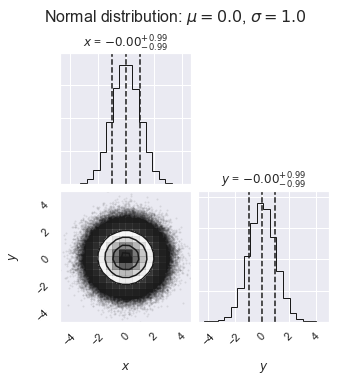

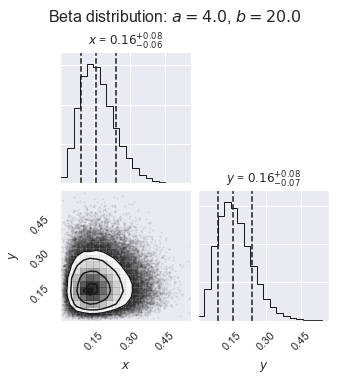

In [6]:
# examples of corner plots
ndim, nsamples = 2, 1000000
#np.random.seed(42)
# generate some synthetic data from a normal distribution
mu, sigma = 0., 1.
norm_samples = stats.norm.rvs(size=ndim * nsamples).reshape([nsamples, ndim])

figure1 = corner.corner(norm_samples, 
                        labels=[r"$x$", r"$y$", r"$\log \alpha$"],
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, title_kwargs={"fontsize": 12})
ax = figure1.get_axes()
my_suptitle = rf'Normal distribution: $\mu = {mu:.1f}$, ' + \
              rf'$\sigma = {sigma:.1f}$'
figure1.suptitle(my_suptitle, y=1.0, va='bottom', fontsize=16)
figure1.set_size_inches(5,5)


ndim, nsamples = 2, 100000
#np.random.seed(42)
# generate some synthetic data from a beta distribution
a = 4
b = 20
beta_samples = stats.beta(a,b).rvs(size=ndim * nsamples) \
                              .reshape([nsamples, ndim])

figure2 = corner.corner(beta_samples, 
                        labels=[r"$x$", r"$y$", r"$\log \alpha$"],
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, title_kwargs={"fontsize": 12})
my_suptitle = rf'Beta distribution: $a = {a:.1f}$, $b = {b:.1f}$'
figure2.suptitle(my_suptitle, y=1.0, va='bottom', fontsize=16)
figure2.set_size_inches(5,5)


*What do you learn from these plots?*

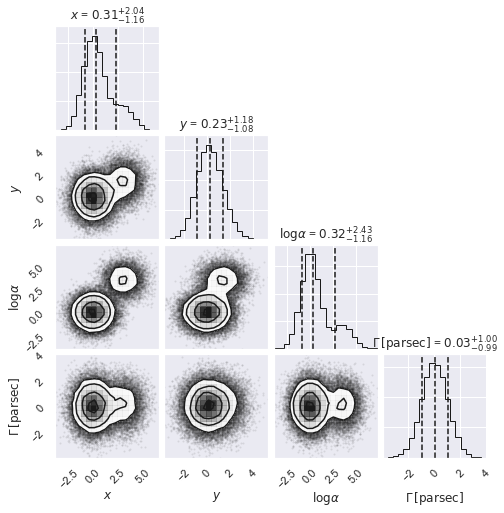

In [7]:
# now more than one mode (all random)
ndim, nsamples = 4, 50000
np.random.seed(1234)
data1 = np.random.randn(ndim * 4 * nsamples // 5) \
          .reshape([4 * nsamples // 5, ndim])
mean = 4*np.random.rand(ndim)
data2 = (mean[None, :] + np.random.randn(ndim * nsamples // 5) \
          .reshape([nsamples // 5, ndim]))
samples = np.vstack([data1, data2])

#figure = corner.corner(samples)
figure = corner.corner(samples, labels=[r"$x$", r"$y$", r"$\log \alpha$", \
                                        r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

figure.set_size_inches(7,7)


*What do you learn from these plots?*

### Sampling of 1d pdfs in Python

Here we show how histogrammed samples become closer to the continuous pdf as the sample size increases.

In [ ]:
def plot_hist(ax, name, x_dist, dist, num_samples, num_bins):
    """Plot a pdf and a histogram of samples"""
    samples = dist.rvs(size=num_samples)  # draw random samples from the pdf
    # Make a histogram of the random samples
    count, bins, ignored = ax.hist(samples, num_bins, density=True,
                                     color='blue', alpha=0.7)
    ax.plot(x_dist, dist.pdf(x_dist), linewidth=2, color='r') # true pdf
    title_string = name + f'  samples = {num_samples:d}'
    ax.set_title(title_string)
    

mu, sigma = 0, 1.0 # mean and standard deviation
x_dist = np.linspace(-4, 4, 500)
name = rf'normal $\mu=${mu:1.1f}, $\sigma=${sigma:1.1f}'
fig = plt.figure(figsize=(15,5))
num_bins = 50

num_samples = 100
norm_dist = stats.norm(mu, sigma)
ax_1 = fig.add_subplot(1, 3, 1)
plot_hist(ax_1, name, x_dist, norm_dist, num_samples, num_bins)

num_samples = 1000
norm_dist = stats.norm(mu, sigma)
ax_2 = fig.add_subplot(1, 3, 2)
plot_hist(ax_2, name, x_dist, norm_dist, num_samples, num_bins)

num_samples = 10000
norm_dist = stats.norm(mu, sigma)
ax_3 = fig.add_subplot(1, 3, 3)
plot_hist(ax_3, name, x_dist, norm_dist, num_samples, num_bins)


To do:
*Find the mean of the random samples and compare to $\mu=0$ for each sample size.  Conclusion?*